# Soft tissue mechanics in FEniCS

**Joakim Sundnes**

Date: **June 24, 2024**


* Solve a simple soft tissue mechanics problem:
  * Elastic unit cube
  * Uniaxial stretch
  * StVenant-Kirchhoff material


## Recap of key quantities 
* $u(t) = x(t) - X$: Displacement, usually the primary unknown of our mechanics problems. 
* ${F} = {I} + \nabla{u}$: Deformation gradient. Used in strain definitions and to map between deformed and undeformed geometries
* ${C} = {F}^T{F}$: Right Cauchy-Green tensor. Measure of pure deformation, free og rigid body translation and rotation, often used in constitutive laws. Not technically strain since ${C} = {I}$ for zero discplacement
* ${E} = 1/2({F}^T{F}-{I}) = 1/2({C}-{I})$: Green-Lagrange strain. The most commonly used strain tensor for large deformations. Extension of the standard, linear small deformation strain.
* ${\sigma}$: Cauchy stress tensor, also called the true stress. Standard stress tensor used for small deformations. Relevant also for large deformations, but inconvinient to use in computations. 
* ${P}, {S}$: First and second Piola-Kirchhoff stress tensors. Stress tensors suitable for large deformations, since they are defined relative to the undeformed geometry. 
* $W$: Strain energy function. Defines the elastic energy stored during a deformation. Used to define material laws, since stress is recovered as ${S} = \partial W/\partial{E}$, etc.



## Example 1: An elastic cube
We start with a simple example, where we consider loading of a unit cube. This simple case will illustrate how to define a non-linear elasticity problem in Fenics, and how to introduce boundary conditions and different material properties. The model will be a simple unit cube, fixed at one end ($x=0$) and loaded with a pressure load (negative pressure, i.e. stretch) at the other end ($x=1.0$). The first version of the model will use a simple isotropic neo-Hookean material model. Later we will introduce a more realistic soft tissue model, and also add active contraction. 


### Weak form of the static hyper-elasticity problem
We want to solve a static solid mechanics problem with a combination of Dirichlet and Neumann boundary conditions:
$$
 \begin{alignat*}{2}
    - \nabla\cdot P &= 0 && \quad \text{ in } \Omega \\
    u &= 0 && \quad \text{ on } \Gamma_{\mathrm{D}} \\
    P \cdot n &= T && \quad \text{ on } \Gamma_{\mathrm{N}} \\
    P \cdot n &= 0 && \quad \text{ on } \Gamma_{\mathrm{0}}
  \end{alignat*}
$$
Here, $P$ is the first Piola-Kirchhoff stress tensor, $u$ is the displacement, $T$ is a load (vector) applied to parts of the boundary, and $\Omega, \Gamma_{\mathrm{D}}, \Gamma_{\mathrm{N}},\Gamma_{\mathrm{0}}$ are the domain and the boundaries for Dirichlet- and Neumann boundary conditions, respectively. 

To apply the finite element method, we need to derive the weak form of the problem.  Multiply by a test function $v \in \hat{V}$ and integrate by parts:
$$
  \begin{equation*}
    - \int_{\Omega} \nabla\cdot P \cdot v dx
    = \int_{\Omega} P : \nabla v dx - \int_{\partial\Omega} (P \cdot n) \cdot v ds = 0
  \end{equation*}
$$

We now apply the boundary conditions (and note that $v = 0$ on $\Gamma_{\mathrm{D}}$), to get the final weak form:

Find $u \in V$ such that
$$
\begin{equation*}
    \int_{\Omega} P : \nabla v dx
    = \int_{\Gamma_{\mathrm{N}}} T \cdot v ds
  \end{equation*}
$$
for all $v \in \hat{V}$ 

In our case the boundary load $T$ is a simple normal pressure. If we were working in the deformed configuration, we would simply have $T=-p n$, where $p$ is the applied pressure and $n$ is the unit surface normal. However, we are using a Lagrangian formulation and everything is defined relative to the reference state. The applied pressure, which actually acts on the deformed surface, therefore needs to be mapped to the reference state. We get
$$
\begin{equation*}
T = -p J F^{-T}\cdot N,
\end{equation*}
$$
where $N$ is the unit normal of the undeformed (reference) geometry. 

### The St Venant-Kirchhoff material model
The simplest hyper-elastic material model is the St Venant-Kirchhoff model, which is simply an extension of the linear Hooke's law to the large-deformation regime. The strain energy function is given by:
$$
\begin{equation*}
    W(E) = \frac{\lambda}{2} (tr(E))^2 + \mu tr(E^2),
  \end{equation*}
  $$
where  $E = \frac{1}{2}(F^T F - I)$ is the Green-Lagrange strain, and $F = I + \nabla u$ is the deformation gradient. From the strain energy function we can obtain the first and second Piola-Kirchhoff (PK) stress ($P$ and $S$) as
$$
\begin{align*}
P_{ij} &= \frac{\partial W}{\partial F_{ij}}, \\
S_{ij} &= \frac{\partial W}{\partial E_{ij}},
\end{align*}
$$
and we also have the relation $P = FS$. Both the first and second PK stresses are commonly used in finite element solvers. The formulation based on $S$ is popular in text books, as it allows a few more analytical steps in the derivation of the nonlinear solution method. However, in a computational setting, and in particular when using an automated system like FEniCS, the formulation based on $P$ is just as simple.

### The Fenics solver
We are now ready to specify the problem in Fenics. First, the usual imports and defining the solution domain, the function space, and the test- and trial functions:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from fenics import *

# Setup the mesh and the function space for the solutions
mesh = UnitCubeMesh(4,4,4)
V = VectorFunctionSpace(mesh, "Lagrange", 2)

# Define functions
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement 

Now we need to define the boundary conditions. We want homogenous Dirichlet conditions on the left boundary $x=0.0$, a non-homoegenous Neumann conditions on $x=1.0$, and homogenous Neumann conditions everywhere else. The following code first defines the subdomains and marks the respective boundaries, then redefines the boundary measure (ds) to allow surface integrals over parts of the boundary, and then defines the Dirichlet conditions:

In [3]:
# Mark boundary subdomains
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

boundary_markers = MeshFunction("size_t", mesh,mesh.topology().dim() - 1)
boundary_markers.set_all(0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)

# Redefine boundary measure
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define Dirichlet boundary (x = 0 or x = 1)
clamp = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, clamp, left)
bcs = [bc]

Next, we turn to defining the mechanics problem. We start with the kinematics and the strain energy function defining the neo-Hookean material, obtain the Piola-Kirchhoff stresses by differentiating the strain energy function, and finally define the weak form of the problem.

### Exercise 

Continue the code below to define all the relevant kinematic quantities, define the weak form, and then solve the problem. 

In [4]:
# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient


load_steps = 5
target_load = 10

loads = np.linspace(0, target_load, load_steps)

for step in range(load_steps):
    pass
    #solve the problem


"""Define the remaining kinematic quantities, stresses, and the weak form.
Then solve the problem.

The code follows the mathematical definitions quite intuitively, but
a couple of tricks are useful to know about:

- We want to differentiate the strain energy function wrt either
  F or E, to obtain, respectively, the PK1 or PK2 stress. The variable
  we differentiate with respect to needs to be identified as a variable, for 
  instance 
  E = 0.5*(C - I) 
  E = variable(E)
  (...)
  S = diff(psi,E)

- The load for the right boundary needs to be incrementally increased in a loop. 
  It can be defined, for instance, as follows:
  p_right = Constant(0.0)
  And then updated inside a loop by
  p_right.assign(load)
  where load is the load we want to apply for the present step.
- A suitable final load can be p_right = 10.0, and we can use, for instance, 5-10 steps to get there
"""


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.455e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.187e-01 (tol = 1.000e-10) r (rel) = 6.331e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.950e-03 (tol = 1.000e-10) r (rel) = 2.880e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.126e-04 (tol = 1.000e-10) r (rel) = 3.258e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.776e-08 (tol = 1.000e-10) r (rel) = 5.142e-08 (tol = 1.000e-09)
  Newton iteration 5: r (

'Define the remaining kinematic quantities, stresses, and the weak form.\nThen solve the problem.\n\nThe code follows the mathematical definitions quite intuitively, but\na couple of tricks are useful to know about:\n\n- We want to differentiate the strain energy function wrt either\n  F or E, to obtain, respectively, the PK1 or PK2 stress. The variable\n  we differentiate with respect to needs to be identified as a variable, for \n  instance \n  E = 0.5*(C - I) \n  E = variable(E)\n  (...)\n  S = diff(psi,E)\n\n- The load for the right boundary needs to be incrementally increased in a loop. \n  It can be defined, for instance, as follows:\n  p_right = Constant(0.0)\n  And then updated inside a loop by\n  p_right.assign(load)\n  where load is the load we want to apply for the present step.\n- A suitable final load can be p_right = 10.0, and we can use, for instance, 5-10 steps to get there\n'

.224e-02 (tol = 1.000e-10) r (rel) = 1.213e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.424e-04 (tol = 1.000e-10) r (rel) = 5.355e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.091e-08 (tol = 1.000e-10) r (rel) = 4.101e-08 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.257e-15 (tol = 1.000e-10) r (rel) = 1.977e-14 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.426e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.913e-02 (tol = 1.000e-10) r (rel) = 7.884e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.374e-05 (tol = 1.000e-10) r (rel) = 1.803e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 8.025e-10 (tol = 1.000e-10) r (rel) = 3.308e-09 (tol = 1.000e-09)
  Newton iterati

## Solution
Click below to expand the cell and see a suggested solution.

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.968e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.029e-01 (tol = 1.000e-10) r (rel) = 5.608e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.571e-02 (tol = 1.000e-10) r (rel) = 6.212e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.827e-03 (tol = 1.000e-10) r (rel) = 4.267e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 2.212e-05 (tol = 1.000e-10) r (rel) = 2.466e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.500e-09 (tol = 1.000e-10) r (rel) = 1.673e-09 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.231e-16 (tol = 1.000e-10) r (rel) = 2.487e-16 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating res

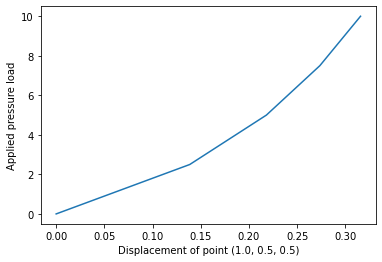

In [5]:
# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # the right Cauchy-Green tensor
E = 0.5*(C - I)             # the Green-Lagrange strain tensor

# Material parameters (Lamé parameters)
mu    = 4.0  
lmbda = 20.0  

# The strain energy for the St-Venant Kirchhoff model:
E = variable(E)
psi = lmbda / 2 * (tr(E)**2) + mu * tr(E * E)

S = diff(psi, E) #second Piola-Kirchhoff stress
P = F * S         #First Piola-Kirchhoff stress

p_right = Constant(0.0) #the pressure load (zero for now)

# Definition of the weak form:
N = FacetNormal(mesh)
Gext = p_right * inner(v, det(F) * inv(F) * N) * ds(2) #ds(2) = left boundary
R = inner(P,grad(v)) * dx + Gext 

#Finally, we solve the problem for different loads, and plot the load vs displacement. 
# The middle point on the right boundary
point0 = np.array([1.0,0.5,0.5])

# Step-wise loading (for plotting and convergence)
load_steps = 5
target_load = 10.0
loads = np.linspace(0, target_load, load_steps)

d0 = np.zeros(3)                #displacement at point0
disp = np.zeros(load_steps) #array to store displacement for all steps

disp_file = XDMFFile("displacement/u.xdmf")

for step in range(load_steps):
    # Stretch is a negative pressure
    p_right.assign(-loads[step])
    
    #solve the problem:
    solve(R == 0, u, bcs)
    
    #evaluate displacement at point defined above
    u.eval(d0,point0)
    disp[step] = d0[0]

    disp_file.write_checkpoint(u, "Displacement", step, append=True)

disp_file.close()

#displacement on x-axis, load on y-axis
plt.figure(1)
plt.plot(disp,loads)
plt.xlabel('Displacement of point (1.0, 0.5, 0.5)')
plt.ylabel('Applied pressure load')

plt.show()

### Questions and comments:
* The neo-Hookean model is a linear stress-strain relation, but the curve above is non-linear. Why?
* An open source cardiac mechanics solver, based on the approach outlined above, can be found here: [https://github.com/finsberg/pulse](https://github.com/finsberg/pulse) 